## PART I
A workflow for inference on the presence of a target object using an MRF. We designed a toy problem to validate whether target object inference matched our intuitions based on simulated co-occurrence statistics. We intend to compare the output of an exact inference algorithm to the manual calcuation of energy. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import VariableElimination, BeliefPropagation, ApproxInference
from pgmpy.sampling import GibbsSampling
import daft
import random
import itertools

c:\Users\karae\anaconda3\envs\vrrl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[0.  0.5 1.  0.2]
 [0.5 0.  0.2 0.1]
 [1.  0.2 0.  1. ]
 [0.2 0.1 1.  0. ]]


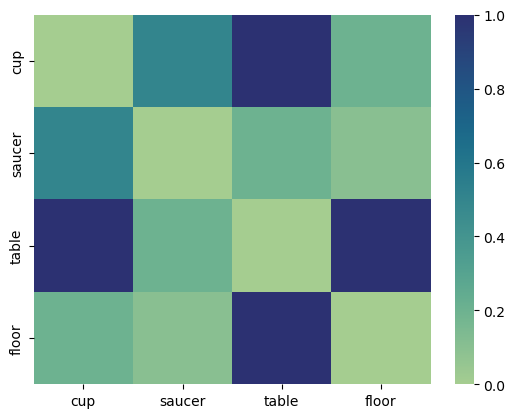

In [623]:
objects = ["cup","saucer","table","floor"]

# counts
cooccur = np.array([[0,5,10,2],
                    [5,0,2,1],
                    [10,2,0,10],
                    [2,1,10,0]])

cooccur = cooccur/np.max(cooccur)

print(cooccur)
sns.heatmap(cooccur,xticklabels=objects,yticklabels=objects,cmap='crest')

#np.fill_diagonal(cooccur,0)
cooccur = pd.DataFrame(cooccur,index=objects,columns=objects)


In [624]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = objects
edges = list(itertools.combinations(objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

<Axes:>

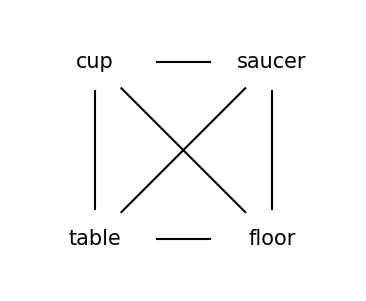

In [625]:
# illustrate graph
pgm = daft.PGM(aspect=2.1, dpi=150, node_unit=1, grid_unit=3, directed=False, node_ec=None)

x = [0, 1, 0, 1]
y = [1, 1, 0, 0]

for i in range(len(nodes)):
    pgm.add_node(nodes[i], nodes[i], x[i], y[i])
    
for i in range(len(edges)):    
    pgm.add_edge(edges[i][0],edges[i][1])
    
pgm.render()

In [626]:
# phi based on Kollar & Roy 2009
def compatibility(edge,cooccur):
    
    tt = cooccur.loc[edge[0],edge[1]] / np.sum(cooccur.loc[edge[0],:])
    ft = (np.sum(cooccur.loc[:,edge[1]])-cooccur.loc[edge[0],edge[1]]) / (np.sum(np.triu(np.asarray(cooccur)))-np.sum(cooccur.loc[edge[0],:]))
    tf = 1 - tt
    ff = 1 - ft

    phi = np.reshape([ff, ft, tf, tt],(2,2))
    
    return phi

In [517]:
# create factors
for e in G.edges():
    factor = DiscreteFactor(e, [2, 2], compatibility(e,cooccur))
    G.add_factors(factor)

In [618]:
def mrf_approx_infer(nodes, cooccur, evidence={}, iterations=1000):

    # total energy calculation
    E = np.zeros(iterations)

    # pregenerate states
    S = pd.DataFrame(np.random.randint(low = 0, high = 2, size = (iterations,len(nodes))),columns = nodes)

    if (len(evidence) > 0):
        for idx, key in enumerate(list(evidence.items())):
            S[key[0]] = key[1]

    # start iterations loop
    for i in range(iterations):
        
        state = S.iloc[i]
        energy = []
        edges = list(itertools.combinations(nodes,r=2))

        for e in range(len(edges)):
        
            psi = compatibility(edges[e],cooccur)[state[edges[e][0]],state[edges[e][1]]]
            energy.append(psi)

        E[i] = np.sum(np.log(energy))

    return S.iloc[np.argmax(E)] # print state with maximum energy 


In [519]:
def mrf_exact_infer(nodes, evidence={}, iterations=1000):

    G_infer = BeliefPropagation(G)
    node_states = pd.DataFrame(np.zeros((1,len(nodes))),index=['state'],columns=nodes)
    
    for i in range(len(list(evidence.keys()))):
        node_states[list(evidence.keys())[i]] = list(evidence.values())[i]
        nodes.remove(list(evidence.keys())[i])

    for n in nodes:
        G_prob = G_infer.query(variables=[n], evidence=evidence)
        node_states[n] = np.argmax((G_prob.values))

    return print(node_states.T)

In [520]:
# mrf exact inference with package
nodes = objects.copy()
evidence = {'saucer': 1}

mrf_exact_infer(nodes,evidence)

        state
cup         1
saucer      1
table       0
floor       0


In [521]:
# mrf approximate inference custom
nodes = objects.copy()
evidence = {'saucer': 1}

mrf_approx_infer(nodes,cooccur,evidence) 

cup       1
saucer    1
table     0
floor     0
Name: 4, dtype: int64

## PART II
 
Below attempts another toy problem with additional objects to verify custom algorithm.

In [612]:
all_objs = pd.read_excel('post_objects.xlsx')
full_objects = []
n = 15

for i in range(n):
    full_objects.append(all_objs.iloc[i][0][6:])

<AxesSubplot:>

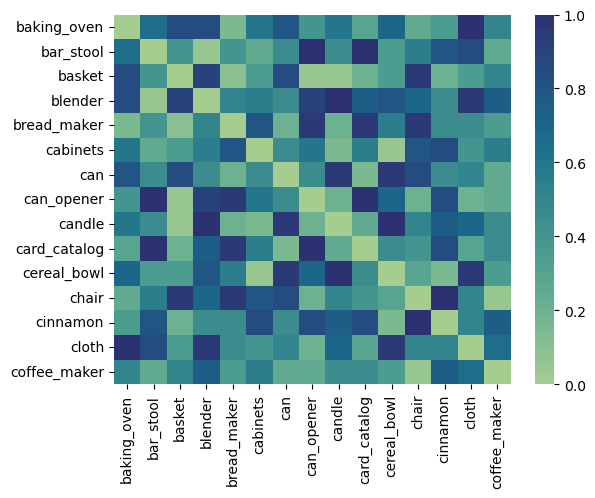

In [613]:
# counts
cooccur = np.random.randint(low=1,high=21,size=(len(full_objects),len(full_objects)))
np.fill_diagonal(cooccur,0)
cooccur = cooccur/np.max(cooccur)
cooccur = np.tril(cooccur)
cooccur = np.maximum(cooccur, cooccur.transpose())
cooccur = pd.DataFrame(cooccur,index=full_objects,columns=full_objects)

sns.heatmap(cooccur,cmap='crest')

In [614]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = full_objects.copy()
edges = list(itertools.combinations(full_objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [615]:
# create factors
for e in G.edges():
    factor = DiscreteFactor(e, [2, 2], compatibility(e,cooccur))
    G.add_factors(factor)

In [616]:
# mrf exact inference with package
nodes = full_objects.copy()
evidence = {'candle': 1, 'chair': 1}

mrf_exact_infer(nodes,evidence)

              state
baking_oven       0
bar_stool         0
basket            0
blender           0
bread_maker       0
cabinets          0
can               0
can_opener        0
candle            1
card_catalog      0
cereal_bowl       0
chair             1
cinnamon          0
cloth             0
coffee_maker      0


In [620]:
# mrf approximate inference custom
nodes = full_objects.copy()
evidence = {'candle': 1, 'chair': 1}
iterations = 100000

mrf_approx_infer(nodes,cooccur,evidence,iterations) 

baking_oven     0
bar_stool       0
basket          0
blender         0
bread_maker     0
cabinets        0
can             0
can_opener      0
candle          1
card_catalog    0
cereal_bowl     0
chair           1
cinnamon        0
cloth           0
coffee_maker    0
Name: 712, dtype: int64

In [609]:
nodes = full_objects.copy()
evidence = {'candle': 1, 'chair': 1}
node_states = pd.DataFrame(None,columns=['objects','states'])
node_states['objects'] = nodes
node_states['states'] = np.zeros((len(nodes),1))
    
for i in list(evidence.keys()):
    node_states.loc[node_states['objects'] == i,'states'] = evidence[i]
    nodes.remove(i)

start_state = list(zip(node_states.objects, node_states.states))


In [ ]:
gibbs = GibbsSampling(G)
gen = gibbs.sample(start_state=start_state,size=100)

In [610]:
start_state

[('baking_oven', 0.0),
 ('bar_stool', 0.0),
 ('basket', 0.0),
 ('blender', 0.0),
 ('bread_maker', 0.0),
 ('cabinets', 0.0),
 ('can', 0.0),
 ('can_opener', 0.0),
 ('candle', 1.0),
 ('card_catalog', 0.0),
 ('cereal_bowl', 0.0),
 ('chair', 1.0),
 ('cinnamon', 0.0),
 ('cloth', 0.0),
 ('coffee_maker', 0.0)]

## PART III
Below attempts the custom approximate inference algorithm on a larger (i.e., a more realistic number) set of objects to test how long it takes to run.

In [321]:
all_objs = pd.read_excel('post_objects.xlsx')
full_objects = []

for i in range(len(all_objs)):
    full_objects.append(all_objs.iloc[i][0][6:])

In [322]:
# counts
cooccur = np.random.randint(low=1,high=21,size=(len(full_objects),len(full_objects)))
np.fill_diagonal(cooccur,0)
cooccur = cooccur/np.max(cooccur)
cooccur = pd.DataFrame(cooccur,index=full_objects,columns=full_objects)

In [301]:
# mrf approximate inference custom
iterations = 10
nodes = full_objects.copy()
evidence = {'baking_oven': 1}

mrf_approx_infer(nodes,cooccur,evidence,iterations)

(baking_oven       1
 bar_stool         1
 basket            1
 blender           1
 bread_maker       1
                  ..
 trash_can         1
 tub               0
 vanity_case       0
 wash_cloth        1
 window_curtain    0
 Name: 7, Length: 97, dtype: int64,
 -8289.056137141104)

## PART IV

Try mrf2d package in R

In [2]:
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.2.0'
os.environ['R_USER'] = 'C:/Users/karae/anaconda3/envs/vrrl/lib/site-packages/rpy2'


import rpy2
print(rpy2.__path__)

['c:\\Users\\karae\\anaconda3\\envs\\vrrl\\lib\\site-packages\\rpy2']


In [3]:
from rpy2.robjects.packages import importr

In [7]:
# Choosing a CRAN Mirror
utils = importr('utils')
base = importr('base')
utils.chooseCRANmirror(ind=1)

utils.install_packages('mrf2d')

R[write to console]: Installing package into 'C:/Users/karae/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)

R[write to console]: also installing the dependencies 'rbibutils', 'Rdpack', 'RcppArmadillo'


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/rbibutils_2.2.13.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 763672 bytes (745 KB)

R[write to console]: downloaded 745 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/Rdpack_2.4.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 957596 bytes (935 KB)

R[write to console]: downloaded 935 KB


R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.2/RcppArmadillo_0.11.4.3.1.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 1975851 bytes (1.9 MB)

R[write to console]: downloaded 1.9 MB


R[write to console]: t

package 'rbibutils' successfully unpacked and MD5 sums checked
package 'Rdpack' successfully unpacked and MD5 sums checked
package 'RcppArmadillo' successfully unpacked and MD5 sums checked
package 'mrf2d' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\karae\AppData\Local\Temp\RtmpEj2Hxz\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x000002DEC174D900> [RTYPES.NILSXP]

In [5]:
from rpy2.robjects.packages import importr
base = importr('base')
print(base._libPaths())

[1] "C:/Users/karae/AppData/Local/R/win-library/4.2"
[2] "C:/Program Files/R/R-4.2.0/library"            



In [8]:
mrf2d = importr('mrf2d')